In [4]:
import torch
from botorch.utils.sampling import draw_sobol_samples
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

def synthetic_objective(x):
    # Assume x is shape (n, 6)
    center = torch.tensor([0.3, 0.7, 0.5, 0.5, 0.2, 0.8])
    scale = 0.05
    return torch.exp(-torch.sum((x - center)**2, dim=-1) / scale)

# 10 initial points in 6D
bounds = torch.tensor([[0.0]*6, [1.0]*6])
X_init = draw_sobol_samples(bounds=bounds, n=10, q=1).squeeze(1)
Y_init = synthetic_objective(X_init).unsqueeze(-1)

gp = SingleTaskGP(X_init, Y_init)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

ucb = UpperConfidenceBound(gp, beta=0.1)  # beta controls exploration
candidate, _ = optimize_acqf(
    acq_function=ucb,
    bounds=bounds,
    q=1,
    num_restarts=10,
    raw_samples=128,
)

# Evaluate new point and update model
new_y = synthetic_objective(candidate).unsqueeze(-1)
X = torch.cat([X_init, candidate], dim=0)
Y = torch.cat([Y_init, new_y], dim=0)

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_19548\4040070722.py:20: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_init, Y_init)


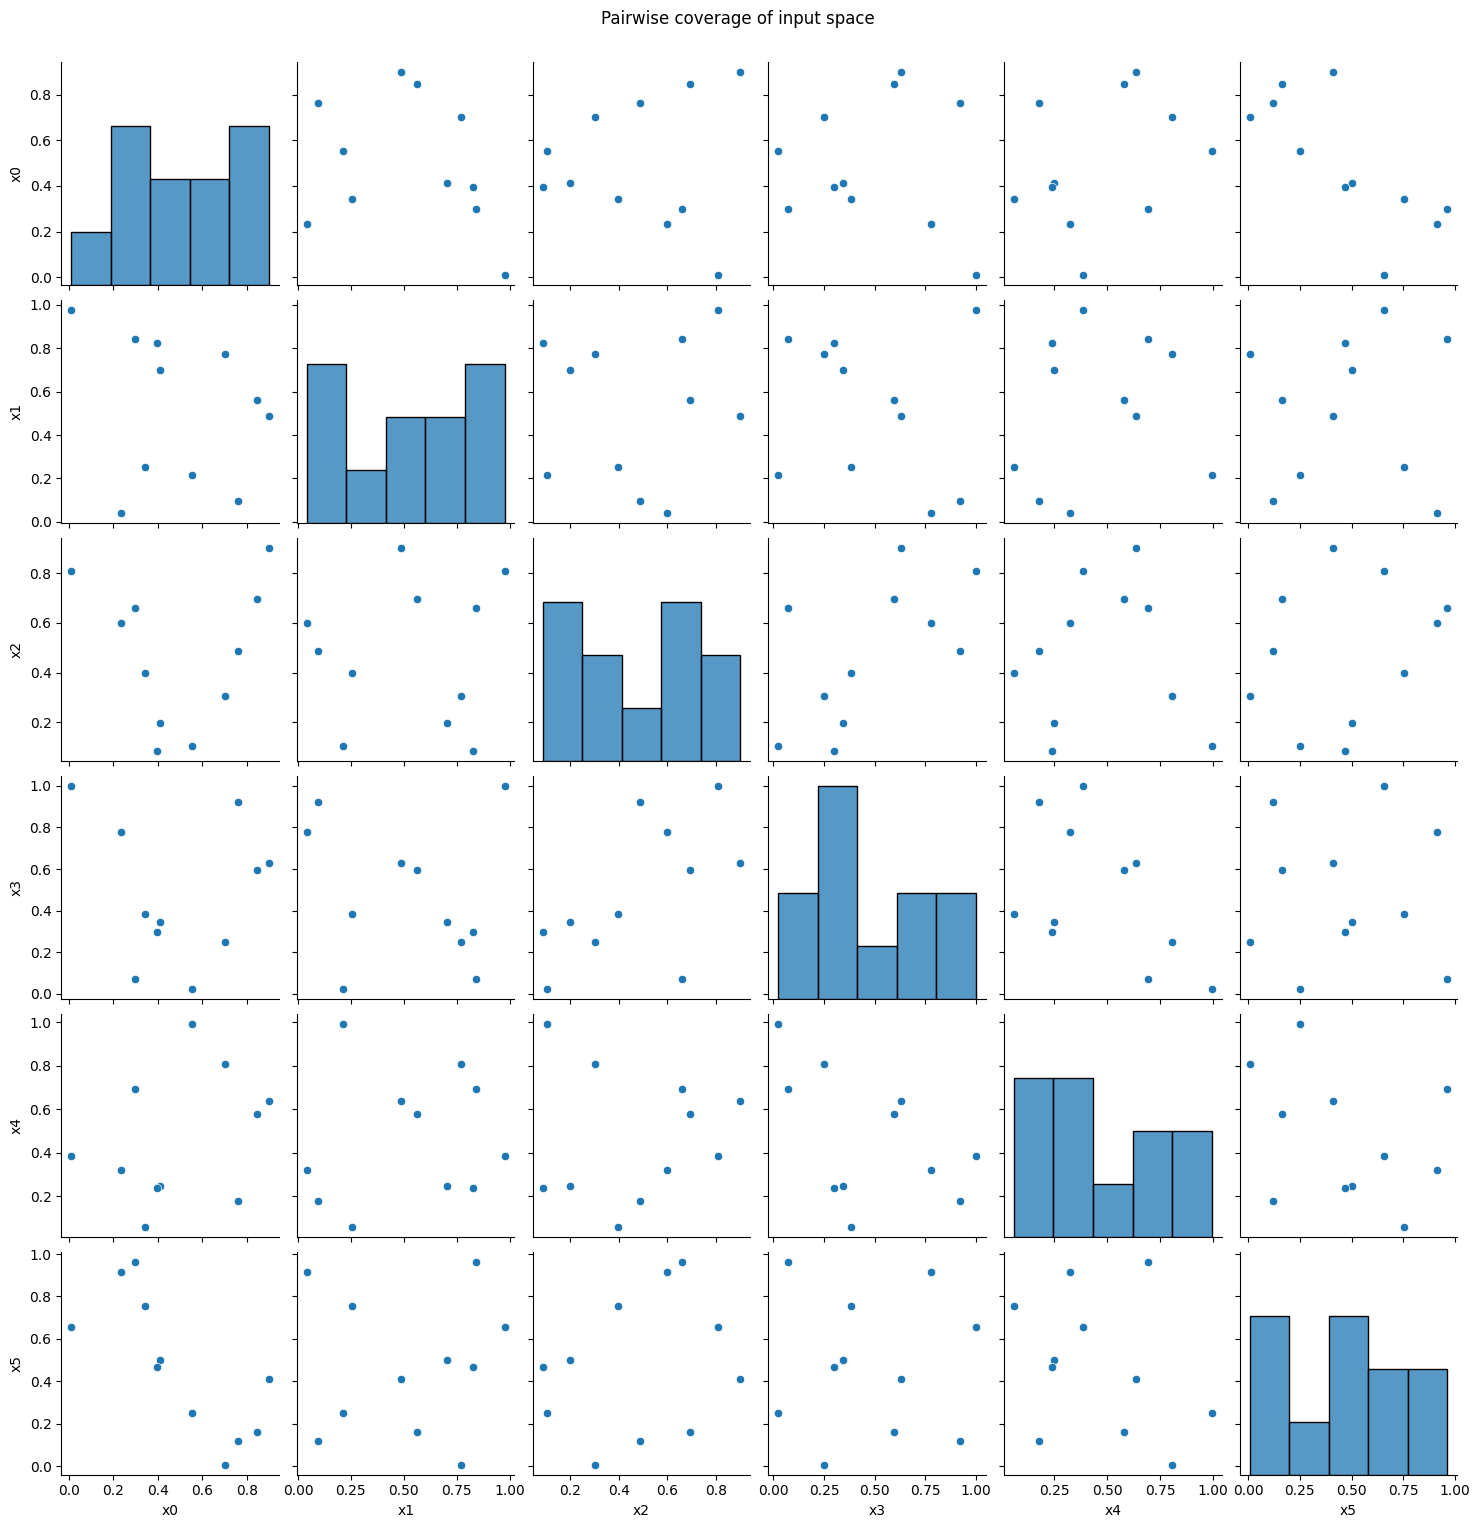

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(X.numpy(), columns=[f"x{i}" for i in range(6)])
sns.pairplot(df)
plt.suptitle("Pairwise coverage of input space", y=1.02)
plt.show()
